In [4]:
import math
import matplotlib.pyplot as plt
import petl
import psycopg2

from lombardi import bayes

# big inline graphs by default
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# suppress bullshit scipy warnings
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# global connection for db
conn = psycopg2.connect('dbname=nfldb')

In [43]:
seasons = petl.fromcsv('seasons.csv').convert('avg_tds', float)
games = petl.fromcsv('games.csv').convert('tds', int)
bucket_data = petl.fromcsv('bucket_data.csv').convert('prob', float)
bucket_td_data = petl.fromcsv('bucket_td_data.csv').convert({'tds': int, 'prob': float})

In [44]:
bucket_probs_list = petl.dicts(bucket_data)
bucket_probs_dict = {r['bucket']: r['prob'] for r in bucket_probs_list}

bucket_td_probs_list = petl.dicts(bucket_td_data)
bucket_td_probs_dict = {r['bucket']: None for r in bucket_td_probs_list}
for b in bucket_td_probs_dict.keys():
    bucket_td_probs_dict[b] = bayes.Pdf({
        r['tds']: r['prob']
        for r in bucket_td_probs_list
        if r['bucket'] == b
    })

In [45]:
seasons_list = petl.dicts(seasons)

In [46]:
seasons_list[0]

{'avg_tds': 1.88,
 'bucket': 'ok',
 'bucket_num': '3',
 'full_name': 'Aaron Rodgers',
 'year': '2009'}

In [47]:
runs = []

for s in seasons_list:
    
    print(s['year'], s['full_name'])
    
    # list of actual tds
    tds = list(games.selecteq('full_name', s['full_name']).selecteq('year', s['year'])['tds'])
    
    dist = bayes.DiscreteBayes(
        prior=bayes.Pdf(dict(bucket_probs_dict)),
        likelihoods=dict(bucket_td_probs_dict),
    )
    
    results = []

    # pre-season
    results.append({
        'prior': dict(dist.prior.probs),
        'posterior_predictive': list(dist.posterior_predictive().probs.values()),
    })

    # track bayesian results week by week
    for num_tds in tds:
        # given number of tds this week, update our prior
        dist.update_prior(num_tds)
        # store results
        results.append({
            'prior': dict(dist.prior.probs),
            'posterior_predictive': list(dist.posterior_predictive().probs.values()),
        })
        
    runs.append({
        'season': s,
        'tds': tds,
        'results': results,
    })

2009 Aaron Rodgers
2009 Carson Palmer
2009 Eli Manning
2009 Joe Flacco
2009 Matt Schaub
2009 Philip Rivers
2009 Tom Brady
2010 Carson Palmer
2010 Drew Brees
2010 Eli Manning
2010 Joe Flacco
2010 Matt Ryan
2010 Matt Schaub
2010 Philip Rivers
2010 Sam Bradford
2010 Tom Brady
2011 Alex Smith
2011 Andy Dalton
2011 Cam Newton
2011 Drew Brees
2011 Eli Manning
2011 Joe Flacco
2011 Mark Sanchez
2011 Matt Ryan
2011 Matthew Stafford
2011 Philip Rivers
2011 Ryan Fitzpatrick
2011 Tom Brady
2012 Aaron Rodgers
2012 Andrew Luck
2012 Andy Dalton
2012 Cam Newton
2012 Drew Brees
2012 Eli Manning
2012 Joe Flacco
2012 Matt Ryan
2012 Matt Schaub
2012 Matthew Stafford
2012 Philip Rivers
2012 Russell Wilson
2012 Ryan Fitzpatrick
2012 Ryan Tannehill
2012 Sam Bradford
2012 Tom Brady
2013 Andrew Luck
2013 Andy Dalton
2013 Ben Roethlisberger
2013 Cam Newton
2013 Carson Palmer
2013 Drew Brees
2013 Eli Manning
2013 Geno Smith
2013 Joe Flacco
2013 Matt Ryan
2013 Matthew Stafford
2013 Philip Rivers
2013 Russell Wils

In [48]:
len(runs)

90

In [49]:
runs[0]['results'][0]

{'posterior_predictive': [0.1463043405805957,
  0.32696003821755115,
  0.2986412771772338,
  0.1496705958160669,
  0.05822621679572496,
  0.016031373943184723,
  0.0041661574696425984],
 'prior': {'bad': 0.033,
  'good': 0.22,
  'great': 0.044,
  'meh': 0.264,
  'ok': 0.429}}

In [51]:
runs[0]['season']

{'avg_tds': 1.88,
 'bucket': 'ok',
 'bucket_num': '3',
 'full_name': 'Aaron Rodgers',
 'year': '2009'}

In [52]:
def expected_value(pp):
    return sum(i*x for i,x in enumerate(pp))


def expected_values(results):
    return [
        expected_value(r['posterior_predictive'])
        for r in results
    ]

def rmse(expected, actual):
    deltas = [e-a for e, a in zip(expected, actual)]
    sq_deltas = [pow(d,2) for d in deltas]
    avg_delta = sum(sq_deltas) / len(sq_deltas)
    rmse = math.sqrt(avg_delta)
    return rmse

In [67]:
for r in runs:
    exp = expected_values(r['results'])
    r['expected_values'] = exp
    r['rmse'] = rmse(exp, r['tds'])
    r['rmse_avg'] = rmse([1.71]*17, r['tds'])

In [68]:
runs[0]['expected_values']

[1.7113130617368986,
 1.64407705315362,
 1.5895710292623628,
 1.6243032781717697,
 1.646172734697456,
 1.662178170477731,
 1.7714081858731618,
 1.856454794003093,
 1.8591939579905676,
 1.8172937562175637,
 1.8217255332151008,
 1.8812465205482038,
 1.9321663774611386,
 1.835512442150199,
 1.880270824238903,
 1.8475977170058848,
 1.8190454747854334]

In [69]:
runs[0]['tds']

[1, 1, 2, 2, 2, 3, 3, 2, 1, 2, 3, 3, 0, 3, 1, 1]

In [70]:
runs[0]['rmse']

0.957520829878429

In [71]:
runs[0]['rmse_avg']

0.9415943925066673

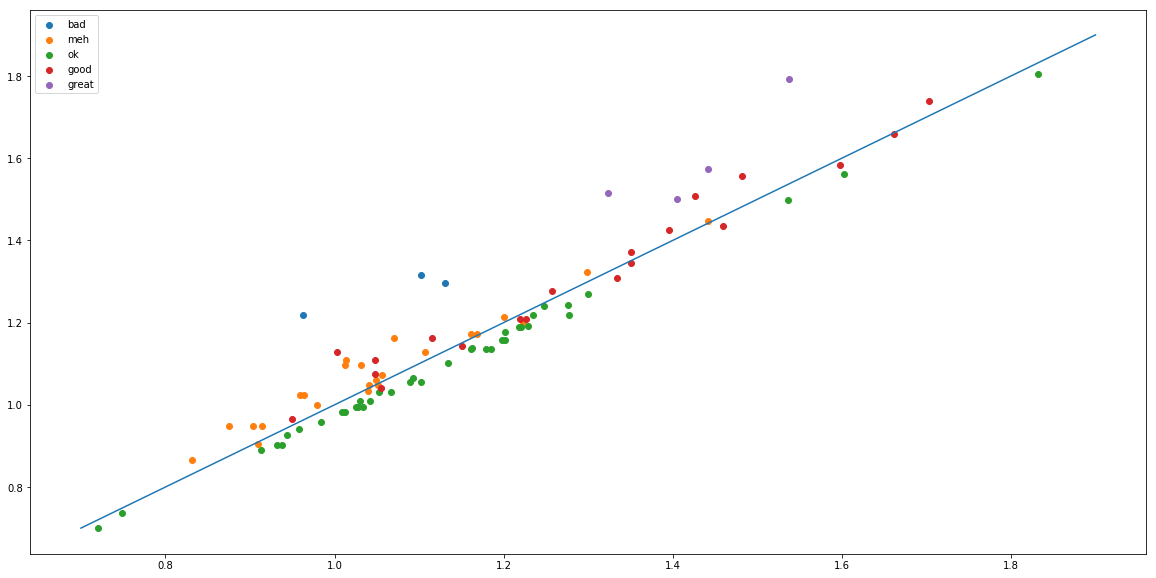

In [80]:
for b in bucket_probs_dict.keys():
    tmp_rmse = [r['rmse'] for r in runs if r['season']['bucket'] == b]
    tmp_rmse_avg = [r['rmse_avg'] for r in runs if r['season']['bucket'] == b]

    plt.scatter(tmp_rmse, tmp_rmse_avg, label=b)
plt.plot([0.7,1.9],[0.7,1.9])
plt.legend()

In [73]:
sum(runs_rmse) / len(runs_rmse)

1.1572188339506115

In [74]:
sum(runs_rmse_avg) / len(runs_rmse_avg)

1.1716116658208078